# ANN Classification - Bank Customer Retention
## Part 2 - ANN TRAINING (Using Pytorch)
In this notebook, we load the preprocessed training and testing dataset files and train ANN models.

> **INPUT:** the preprocessed training and testing dataset files.<br>
> **OUTPUT:** the trained ANN models.

### 1. INITIALIZATION

In [16]:
# Import necessary libraries and modules
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# Check pytorch version
torch.__version__

'2.2.2'

### 2. LOADING DATASET FILES

In [3]:
# Prepare file location and load dataset
data_file_location = "..\\data\\interim\\"
data_train_file_name = "churn_modelling_preprocessed_train"
data_test_file_name = "churn_modelling_preprocessed_test"
data_file_ext = "csv"

data_train = pd.read_csv(data_file_location + data_train_file_name + "." + data_file_ext)
data_test = pd.read_csv(data_file_location + data_test_file_name + "." + data_file_ext)

In [4]:
# Check training dataset head
data_train.head()

,Geography_Germany,Geography_Spain,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.569844,1.743090,0.169582,-1.091687,-0.464608,0.006661,-1.215717,0.809503,0.642595,-1.032270,1.106432,0.0
1,1.754865,-0.573694,-2.304559,0.916013,0.301026,-1.377440,-0.006312,-0.921591,0.642595,0.968738,-0.748664,0.0
2,-0.569844,-0.573694,-1.191196,-1.091687,-0.943129,-1.031415,0.579935,-0.921591,0.642595,-1.032270,1.485335,0.0
3,-0.569844,1.743090,0.035566,0.916013,0.109617,0.006661,0.473128,-0.921591,0.642595,-1.032270,1.276528,0.0
4,-0.569844,1.743090,2.056114,-1.091687,1.736588,1.044737,0.810193,0.809503,0.642595,0.968738,0.558378,0.0


In [5]:
# Check testing dataset head
data_test.head()

,Geography_Germany,Geography_Spain,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1.754865,-0.573694,-0.552043,-1.091687,-0.368904,1.044737,0.879303,-0.921591,0.642595,0.968738,1.610857,0.0
1,-0.569844,-0.573694,-1.314903,-1.091687,0.109617,-1.031415,0.429722,-0.921591,0.642595,-1.032270,0.495870,1.0
2,-0.569844,1.743090,0.571630,-1.091687,0.301026,1.044737,0.308583,-0.921591,0.642595,0.968738,-0.424787,0.0
3,-0.569844,-0.573694,1.416961,0.916013,-0.656016,-0.339364,0.575336,-0.921591,-1.556190,-1.032270,-0.187777,0.0
4,1.754865,-0.573694,0.571630,0.916013,-0.081791,0.006661,1.389611,0.809503,0.642595,0.968738,0.616842,0.0


In [6]:
# Split dataset files into independent and dependent features
# X_train = data_train.iloc[:,0:-1]
# y_train = data_train.iloc[:,-1].values
# X_test = data_test.iloc[:,0:-1]
# y_test = data_test.iloc[:,-1].values

### 2. PREPARING DATASET CLASS

In [7]:
# Data class and its methods
class ChurnModelingData(Dataset):
    
    def __init__(self, data):
        # Split dataset into independent and dependent features
        self.X = data.iloc[:,0:-1].values
        self.y = data.iloc[:,-1].values.reshape(-1,1)
    
    def __getitem__(self, index):
        X = torch.tensor(self.X[index], dtype=torch.float32)
        y = torch.tensor(self.y[index], dtype=torch.float32)
        return X, y
    
    def __len__(self):
        return len(self.y)
    
    def get_features_num(self):
        return self.X.shape[1]

In [8]:
# Data object and loader
churn_data_train = ChurnModelingData(data_train)
train_loader = DataLoader(churn_data_train, batch_size = 32, shuffle = True)
churn_data_test = ChurnModelingData(data_test)

### 3. BUILDING ANN MODEL

In [9]:
# Define ANN class
class CustomerRetentionNetwork(nn.Module):
    
    def __init__(self, num_features):
        super().__init__()
        
        # Define first hidden layer
        self.lin1 = nn.Linear(num_features, 6)
        
        # Define second hidden layer
        self.lin2 = nn.Linear(6, 6)
        
        # Define output layer
        self.lin3 = nn.Linear(6, 1)
        
        # Define sigmoid activation function
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Define data flows through the network
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.sigmoid(x)
        return x

In [10]:
# Initialize ann model
ann = CustomerRetentionNetwork(num_features = churn_data_train.get_features_num())

In [11]:
# Loss function: Binary Cross Entropy Loss for binary classification
criterion = nn.BCELoss()

In [12]:
# Optimizer
optimizer = torch.optim.Adam(ann.parameters(), lr = 0.001)

### 4. TRAINING ANN MODEL

In [13]:
# Epochs number
num_epochs = 100

# Accuracy tracker
accuracy_scores = []

# Training loops
for epoch in range(num_epochs):
    # Set model to training mode
    ann.train()
    
    # Initialize epoch loss and metrics trackers
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    for X_batch, y_batch in train_loader:
        
        # Initialize gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = ann(X_batch)
        
        # Calculate losses
        loss = criterion(output, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
        
        # Convert outputs to binary predictions
        preds = (output > 0.5).float()
        
        # Collect predictions and true labels for this batch
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())
        
    # Calculate metrics for the entire epoch
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    accuracy_scores.append(accuracy)
    
    # Log epoch metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Epoch [1/100], Loss: 0.5284, Accuracy: 0.7961, F1 Score: 0.0012, Precision: 1.0000, Recall: 0.0006
Epoch [2/100], Loss: 0.4426, Accuracy: 0.7965, F1 Score: 0.0049, Precision: 1.0000, Recall: 0.0025
Epoch [3/100], Loss: 0.4219, Accuracy: 0.8070, F1 Score: 0.1848, Precision: 0.6679, Recall: 0.1072
Epoch [4/100], Loss: 0.4084, Accuracy: 0.8221, F1 Score: 0.3558, Precision: 0.6811, Recall: 0.2408
Epoch [5/100], Loss: 0.3958, Accuracy: 0.8284, F1 Score: 0.4343, Precision: 0.6629, Recall: 0.3229
Epoch [6/100], Loss: 0.3837, Accuracy: 0.8374, F1 Score: 0.4839, Precision: 0.6862, Recall: 0.3738
Epoch [7/100], Loss: 0.3739, Accuracy: 0.8445, F1 Score: 0.5152, Precision: 0.7077, Recall: 0.4050
Epoch [8/100], Loss: 0.3660, Accuracy: 0.8470, F1 Score: 0.5367, Precision: 0.7020, Recall: 0.4344
Epoch [9/100], Loss: 0.3599, Accuracy: 0.8504, F1 Score: 0.5485, Precision: 0.7134, Recall: 0.4455
Epoch [10/100], Loss: 0.3551, Accuracy: 0.8542, F1 Score: 0.5636, Precision: 0.7240, Recall: 0.4614
Epoch [11

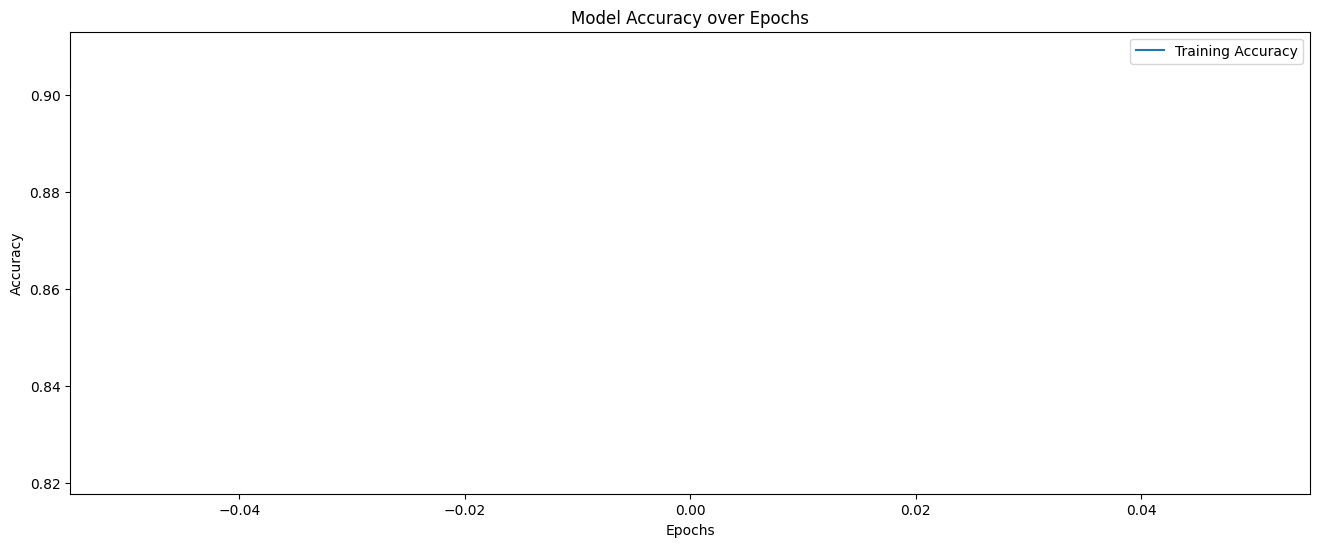

In [17]:
# Plot the training accuracy
plt.figure(figsize=(16,6))
plt.plot(accuracy_scores, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.show()

### 5. EVALUATION

In [ ]:
# Set the model to evaluation mode
ann.eval()

# Convert input data to PyTorch tensor
X_test = torch.tensor(churn_data_test.X, dtype=torch.float32)
y_test = torch.tensor(churn_data_test.y, dtype=torch.float32)

# Disable gradient computation
with torch.no_grad():
    # Forward pass
    output = ann(X_test)
        
    # Convert outputs to binary predictions
    preds = (output > 0.5).float().squeeze().cpu().numpy()

# Extract true labels
true_labels = y_test.numpy()


In [ ]:
# Calculate metrics for the test set
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, zero_division=1)
precision = precision_score(true_labels, preds, zero_division=1)
recall = recall_score(true_labels, preds, zero_division=1)

# Calculate performance metrics
results = pd.DataFrame(index=["ANN Base"], columns=["Accuracy", "Recall", "Precision", "F1"])
results.iloc[0] = [accuracy, recall, precision, f1]

In [ ]:
# Print results
results

The model achieves a high overall accuracy, but it struggles with recall, indicating it misses many positive cases, though its precision shows it is relatively good at correctly identifying the positive cases it does predict.